# Approximating MaxCut Solutions with Variational Quantum Algorithms

The MaxCut problem is an NP-hard combinatorial optimization problem, formulated as follows: Given an undirected graph $G = (V, E)$, what is the optimal partition of the graph's nodes into 2 complimentary subsets, such that a maximal number of edges connects between the 2 subsets?

No efficient classical solution is known for this problem (NP-hard), but there exist some classical algorithms that provide approximated solutions, of whom the most known and successful is the Goemans-Williamson algorithm which is efficient and achieves an approximation ratio of $0.87856$.

An interesting question is whether quantum computers can offer an improvement compared to the best-known classical method described above. In this notebook we go over 2 variational quantum methods to approximate solutions for MaxCut problems - namely QAOA and QEMC.

But before we dive into that, first let's create a random 3-regular graph object with 8 nodes:

Text(0.5, 1.0, 'Graph G=(V, E)')

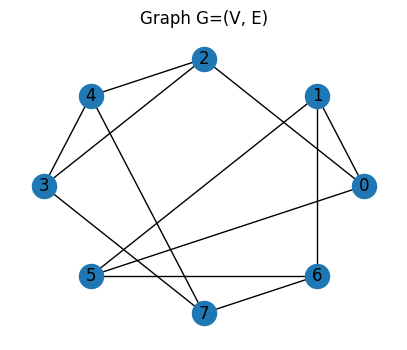

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

num_nodes = 8
degree = 3

graph = nx.generators.random_graphs.random_regular_graph(degree, num_nodes)
pos = nx.circular_layout(graph)

fig_1, axes_1 = plt.subplots(1, 1, figsize=(5, 4))
nx.draw(graph, with_labels=True, pos=pos)
axes_1.set_title("Graph G=(V, E)")

Since this graph is small, it is easy to find the exact optimal partitions for the MaxCut problem by brute-force.

The following piece of code does that by encoding the state of the graph's nodes into a bitstring, where every bit indicates to which subset belongs each node, using little-endian convention. E.g if the rightmost bit is $0$ then node $0$ belongs to the red subset. If the leftmost bit is $1$ then node $7$ belongs to the blue subset, and so on.

Therefore we have executed a brute-force search and drawn the optimal partitions (exact implementation in [classical_functions.py](classical_functions.py)):

Optimal partition score = 10.
The optimal MaxCut partitions for the given graph are:


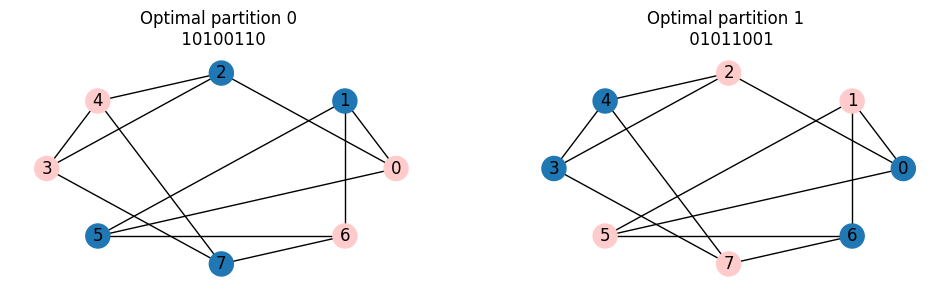

In [56]:
from classical_functions import brute_force_maxcut, partition_draw

exact_analysis = brute_force_maxcut(graph)
optimal_partitions = list(exact_analysis.optimal_partitions)
    
fig_0, axes_0 = plt.subplots(1, len(optimal_partitions), figsize=(12, 3))

print(f"Optimal partition score = {exact_analysis.best_score}.")
print("The optimal MaxCut partitions for the given graph are:")

for index, bitstring in enumerate(optimal_partitions):
    partition_draw(graph, bitstring, axes_0[index], pos)
    axes_0[index].set_title(f"Optimal partition {index} \n {bitstring}")

## QAOA

The overall scheme of the QAOA is a hybrid classical-quantum (as any VQA). The quantum part of QAOA is essentially an Ansatz circuit used to express a quantum state that yields an approximated solution for the MaxCut problem upon measurement. In each QAOA iteration the Ansatz circuit is executed multiple times in order to estimate the expectation value of the cost function. Then a classical optimizer tries to optimize the cost function, and it feeds the Ansatz with new parameters for the next iteration. The process is repeated until convergence.

In QAOA, each graph's node is mapped to a single qubit, therefore the Ansatz contains exactly $|V|$ qubits. The Ansatz is built of the following components: the first layer is a column of $H$ gates over all the qubits that transform the quantum state to $|+\rangle^{\otimes |V|}$. Then $p$ layers of the parameterized unitary transformations $U_C(\gamma_l)$ and $U_B(\beta_l)$ are applied (each layer consists of a single $U_C(\gamma_l)$ followed by a single $U_B(\beta_l)$). $U_C$ and $U_B$ are unitary evolutions of the corresponding Hamiltonians $H_C$ (the "cost Hamiltonian") and $H_B$ (the "mixer Hamiltonian"). Finally, a standard $Z$ basis measurement is performed on all qubits. Therefore the quantum state of the system just before the measurement is expressed as follows:

$$\big|\psi(\vec{\gamma}, \vec{\beta})\big\rangle = \prod_{l=1}^{p}{\big[ U_{B}(\beta_l) \ U_{C}(\gamma_l) \big]}\ |+\rangle^{\otimes |V|} = \prod_{l=1}^{p}{\big[ e^{-iH_{B}\beta_l} \ e^{-iH_{C}\gamma_l} \big]}\ |+\rangle^{\otimes |V|} \tag{1}$$

The MaxCut problem is encoded into the quantum circuit using the cost Hamiltonian $H_C$. Since we aspire that every two adjacent nodes of the graph will be of different subsets, we may define $H_C$ as:

$$H_C = \sum_{(i,\ j)\ \in\ E}\frac{1}{2}(1 - Z_iZ_j) \tag{2}$$

Where $Z_k$ indicates a $Z$ operation on the $k$-th qubit and a trivial operation for all other qubits in the circuit. $Z$ yields a $+1$ eigenvalue for its $|0\rangle$ eigenstate and a $-1$ eigenvalue for its $|1\rangle$ eigenstate. Therefore it is straightforward to see that two distinct adjacent nodes contribute $1$ to the cost function, while in the case of two adjacent nodes of the same subset, no contribution occurs.

There are several ways to construct $U_C$. The method we choose in this notebook is constructing $H_C$ only from the $Z_k$ terms, then after exponentiation it is simple to construct $U_C$ from $RZZ$ gates (a circuit diagram appears in the next section) - one $RZZ$ gate for each graph's edge. In the scope of this notebook we will not derive the exact manner of how this combination of $RZZ$ gates constructs $U_C$. Finally, the rest of $H_C$ is post-computed classically. By multiple executions of the Ansatz circuit (with the same values of $\gamma$ and $\beta$ we can now evaluate the value of the cost function, that is the expectation value of $H_C$:

$$C(G) = \langle \psi(\vec{\gamma}, \vec{\beta})|\ H_C\ |\psi(\vec{\gamma}, \vec{\beta})\rangle \tag{3}$$

$U_B$ has a much more heuristical role, that is ensuring the expressibility of $|\psi(\vec{\gamma}, \vec{\beta})\rangle$ by granting the quantum state a certain amount of $X$ rotation. It consists of a single column of $R_X$ gates over all qubits.

All $RZZ$ gates of a single $U_C(\gamma_l)$ are parameterized by $2\gamma_l$. In a similar manner, all $R_X$ gates of a single $U_B(\beta_l)$ are parameterized by $2\beta_l$. Therefore both $\vec{\gamma}$ and $\vec{\beta}$ are of length $p$. In principle, the more layers we add to the Ansatz, the better approximations we get. But of course this has a computational overhead along with an accumulation of quantum noise as the Ansatz gets deeper.

### Implementation

A dedicated Qiskit interface has been built to approximate solutions for MaxCut using QAOA - `MaxCutQAOA` class ([qaoa_implementation.py](qaoa_implementation.py)). We begin by constructing a suitable Ansatz with $p = 1$ layers:

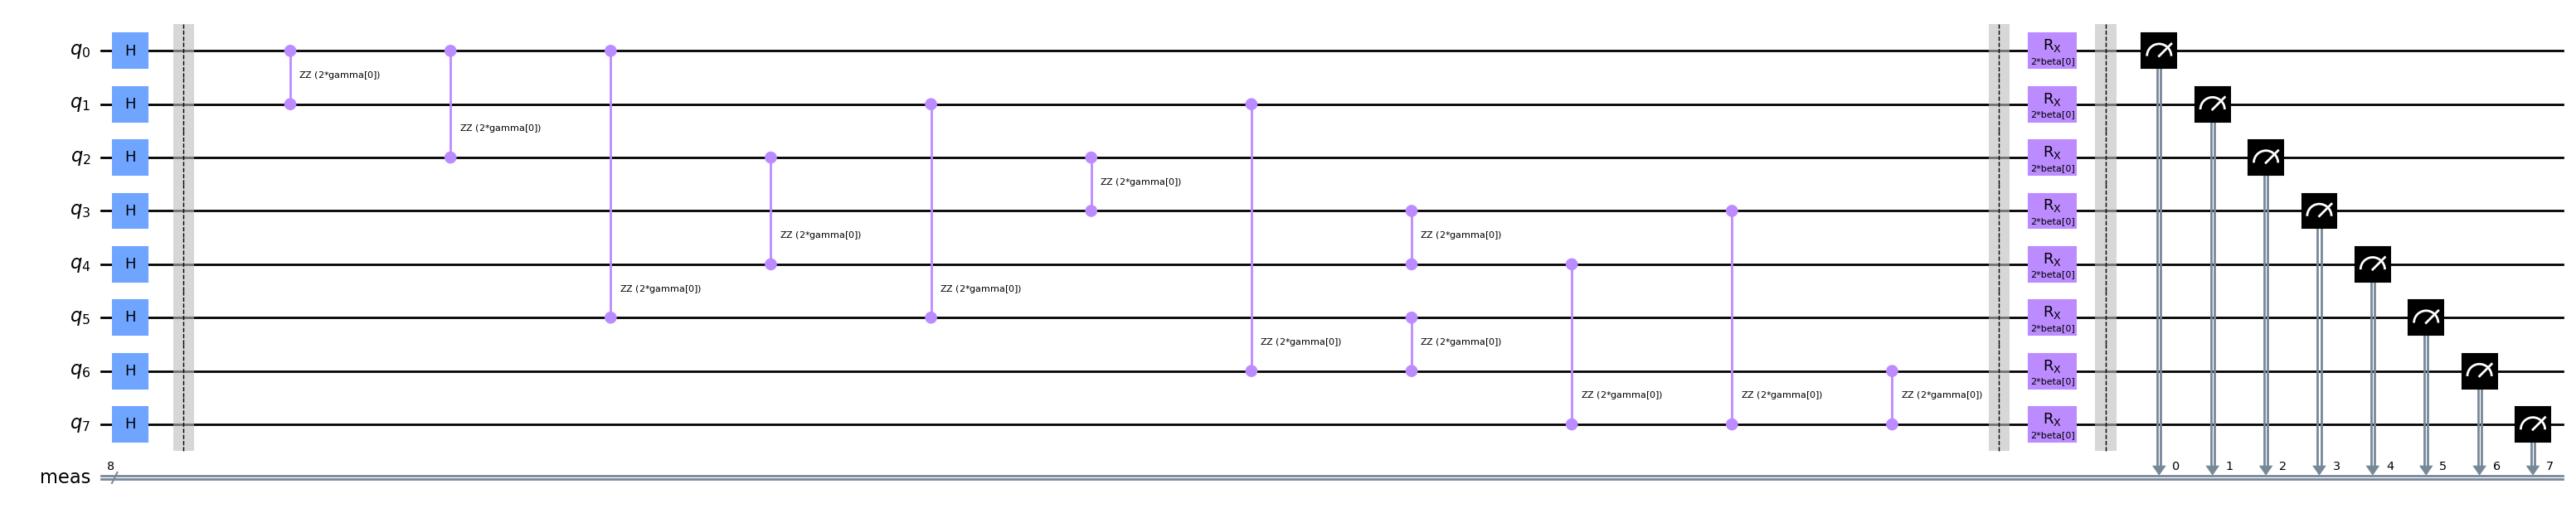

In [57]:
from qaoa_implementation import MaxCutQAOA
qaoa_int = MaxCutQAOA(graph)

ansatz = qaoa_int.construct_ansatz(num_layers=1)
ansatz.draw(output="mpl", fold=-1)

Now, we run the QAOA algorithm using the `FakeGuadlupeV2` backend (i.e a classical simulator that imitates the noise model of the `ibm_guadlupe` superconducting quantum computer), and using the other default settings of the `MaxCutQAOA.run` method - that is 1024 executions (`shots`) of the Ansatz in each cost function evaluation, random initial parameters (`x0`) and the "COBYLA" optimizer (`optimizer_method`):

The best approximated solution is 10100110.


Text(0.5, 1.0, 'Partition for 10100110')

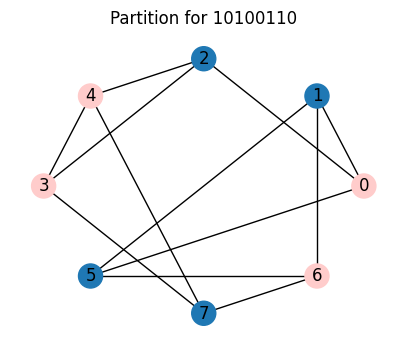

In [58]:
from qiskit.providers.fake_provider import FakeGuadalupeV2

qaoa_result = qaoa_int.run(ansatz=ansatz, backend=FakeGuadalupeV2())

# The first item is the most measured (bitstring, counts) tuple
best_appx_partition = qaoa_result.appx_optimal_counts[0][0]
print(f"The best approximated solution is {best_appx_partition}.")

fig_2, axes_2 = plt.subplots(1, 1, figsize=(5, 4))
partition_draw(graph, best_appx_partition, ax=axes_2, pos=pos)
axes_2.set_title(f"Partition for {best_appx_partition}")

We can check that indeed the solution provided is optimal (or maybe not..):

In [59]:
best_appx_partition in optimal_partitions

True

------------

## QEMC

QEMC (Qubit-Efficient MaxCut Solver) is also a heuristic VQA that approximates solutions for MaxCut problems, but with an exponential improvement in qubits-consumption compared to QAOA. While QAOA maps each node in the given graph to a single qubit ($|V|$ qubits overall), QEMC requires only $log(|V|)$ qubits - by mapping each node into a computational basis state of the Hilbert space spanned by the quantum system. E.g let $V = \{0, 1, 2, 3\}$, then it can be encoded into a quantum circuit with $2$ qubits that spans a Hilbert space with a computational basis $\{ |00\rangle, |01\rangle, |10\rangle, |11\rangle \}$.

Like in QAOA (and as in any other VQA) the design scheme is classical-quantum hybrid. The Ansatz used in QEMC is even more heuristical than the one used in QAOA - no Hamiltonian is encoded into the circuit but rather it consists of a mixture of gates designed to be "expressive", i.e much of the Hilbert space spanned by the quantum system is reachable by tuning the Ansatz's parameters.

The cost function QEMC seeks to optimize is:

$$C(G) = \sum_{(j,k)\ \in\ E} \big[ \big(d(j,k) - \frac{1}{B} \big)^2 + \big(s(j,k) - \frac{1}{B} \big)^2 \big] \tag{4}$$

Where $B$ is the number of *blue* nodes in the partition we seek for, and:

$$d(j,k) = |p(j) - p(k)| \tag{5}$$

$$s(j,k) = p(j) + p(k) \tag{6}$$

I.e, $d(j,k)$ is the absolute value of the difference between node $j$ and node $k$ measured probabilities, and $s(j,k)$ is their sum.

By minimizing $C(G)$ we essentially ask for each $p(j)$ and $p(k)$ to "stay away" one from the other as "far" as possible. Thus, it makes sense to pick the middle point between $p = 0$ to $p = \frac{1}{B}$ as a classifier between *blue* and *red* nodes - we call it the *threshold probability* denoted $p_{th} = \frac{1}{2B}$. States with measured probabilities above $p_{th}$ can now be classified as *blue* nodes, and the other states with measured probabilities below $p_{th}$ can be classified as *red* nodes. Since the number of *blue* nodes is not known apriori, a reasonable value for $B$ would be $B = \frac{|V|}{2}$, assuming that a good partition of the graph's nodes splits it roughly to 2 equally-sized subsets.

It is interesting to note that this type of problem encoding is not just very efficient in terms of qubits-consumption, but also more resilient to noise - the partition to 2 subsets is somewhat "digital" and therefore can tolerate significant noise levels.

Now we implement QEMC using the `QEMC` class (in [qemc_implementation.py](qemc_implementation.py)), trying to approximate a MaxCut solution for the same graph as before. First, we construct an Ansatz circuit with 3 layers (3 is an arbitrary number chosen for simplification, the method of choosing a proper number of layers is out of this notebook's scope):

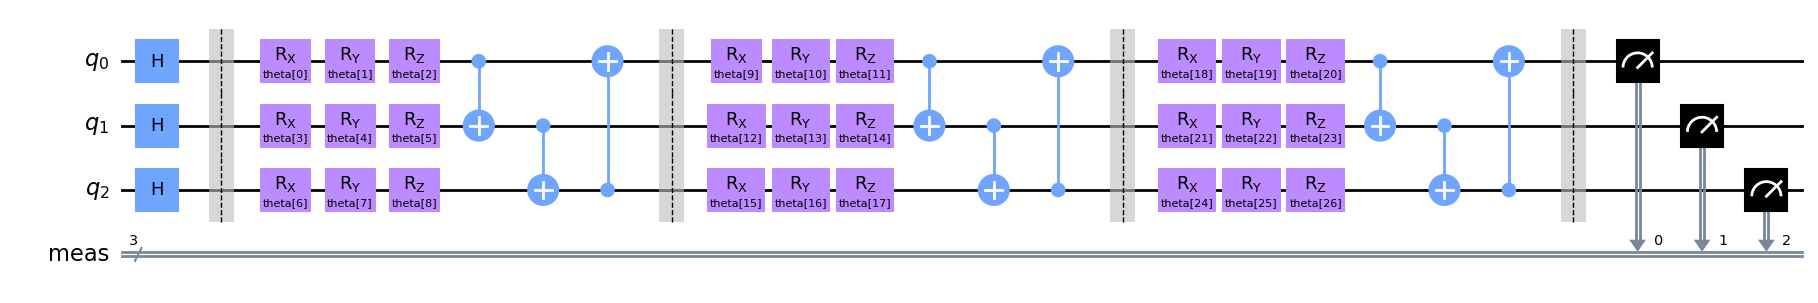

In [60]:
from qemc_implementation import QEMC

qemc_int = QEMC(graph)
ansatz = qemc_int.construct_ansatz(num_layers=3)

ansatz.draw("mpl", fold=-1)

Then we run the QEMC algorithm using the same default values as we did in the previous QAOA section, also using `FakeGuadulupeV2`:

Indeed, the following partition is an optimal MaxCut partition for the given graph (optimal partition 1):


Text(0.5, 1.0, 'QEMC approximated partition')

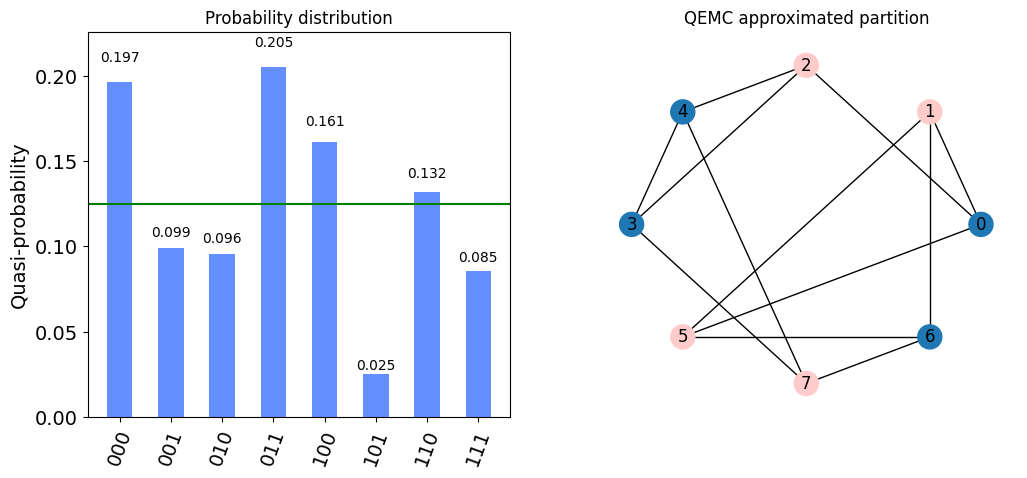

In [66]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.visualization import plot_distribution

qemc_res = qemc_int.run(backend=FakeGuadalupeV2(), optimizer_method="COBYLA", shots=3_000)
partition_bitstring = qemc_res.best_partition_bitstring

if partition_bitstring in exact_analysis.optimal_partitions:
    print("Indeed, the following partition is an optimal MaxCut partition for the given graph" \
          f" (optimal partition {optimal_partitions.index(partition_bitstring)}):"
    )
    
fig_3, axes_3 = plt.subplots(1, 2, figsize=(12, 5))

plot_distribution(qemc_res.best_counts, ax=axes_3[0])
axes_3[0].axhline(qemc_int.probability_threshold, color="green")
axes_3[0].set_title("Probability distribution")

partition_draw(
    graph=graph,
    bitstring=partition_bitstring,
    ax=axes_3[1],
    pos=pos
)
axes_3[1].set_title("QEMC approximated partition")    

And the convergence pattern can be seen in the following cells. The optimal cut-score (10 in this case) is first reached after 21 iterations, while full convergence arrives after around ~100 iterations:

In [109]:
print(f"Best first-reached cut-scores (iteration number, cut-score): {qemc_int.best_scores}")

Best first-reached cut-scores (iteration number, cut-score): OrderedDict([(1, 8), (15, 9), (21, 10), (262, 10)])


Text(0.5, 1.0, 'Best cut score record')

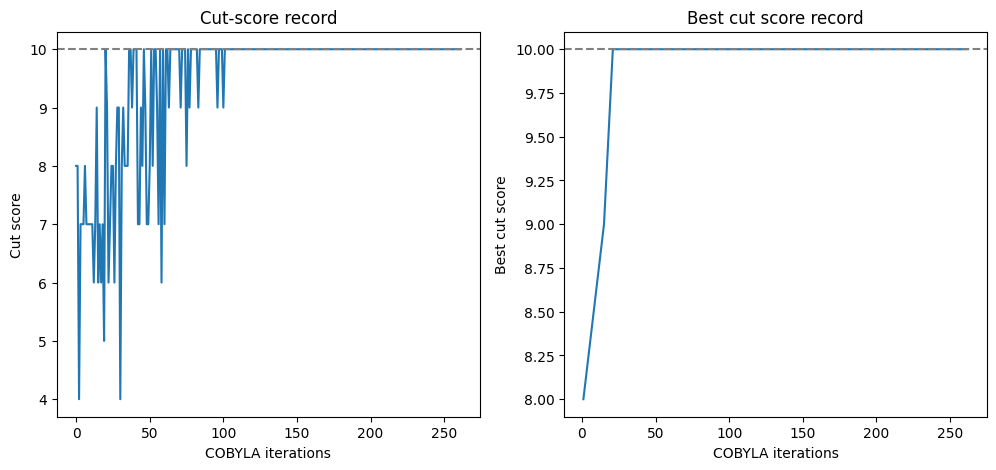

In [110]:
fig_4, axes_4 = plt.subplots(1, 2, figsize=(12, 5))

axes_4[0].plot(cobyla_iters, qemc_int.cut_scores)
axes_4[0].axhline(10, color="grey", linestyle="--")
axes_4[0].set_xlabel("COBYLA iterations")
axes_4[0].set_ylabel("Cut score")
axes_4[0].set_title("Cut-score record")

axes_4[1].plot(qemc_int.best_scores.keys(), qemc_int.best_scores.values())
axes_4[1].axhline(10, color="grey", linestyle="--")
axes_4[1].set_xlabel("COBYLA iterations")
axes_4[1].set_ylabel("Best cut score")
axes_4[1].set_title("Best cut score record")